# LGBMRegressor를 이용한 삼성전자의 다음날 종가&상승or하락 예측

1990년 1월 1일부터 2022년 12월 31일의 데이터로 2023년의 삼성전자 주가를 예측합니다.

In [1]:
!pip install finance-datareader

FinanceDataReader 라이브러리로 1990년 1월 1일부터 2023년 8월 4일까지의 삼성전자 주가 데이터를 불러옵니다.

먼저, 직전 몇 거래일 동안의 데이터로 다음날 종가를 예측할지 결정합니다.
<br>
<br>
이를 위해, 5~200일 중 가장 결정계수 값이 높은 수를 찾습니다.

35개의 직전 거래일 데이터를 사용하는 것이 가장 결정계수값이 높았습니다.
<br>
<br>
이제 모델을 학습해보겠습니다.

In [223]:
import FinanceDataReader as fdr

df = fdr.DataReader('005930')
df

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1999-04-27,1976,2035,1907,1925,1090788,NaN
1999-04-28,1917,1954,1909,1925,608370,0.000000
1999-04-29,1917,1917,1819,1820,739553,-0.054545
1999-04-30,1817,1817,1757,1788,1128711,-0.017582
1999-05-03,1798,1800,1770,1785,435785,-0.001678
...,...,...,...,...,...,...
2023-08-01,70100,71200,70000,71100,12299254,0.018625
2023-08-02,70700,71000,69800,69900,13835020,-0.016878
2023-08-03,69900,70200,68500,68800,20087090,-0.015737


In [224]:
# 이동평균을 계산하는 함수를 정의합니다.
def calculate_moving_average(df, column, window):
    return df[column].rolling(window=window).mean()

# 여러 이동평균 기간을 설정합니다.
moving_average_periods = [5, 10, 20, 60, 120, 240]

# 이동평균을 구하고 데이터 프레임에 새 열로 추가합니다.
for period in moving_average_periods:
    column_name = f"MA_{period}"
    df[column_name] = calculate_moving_average(df, 'Close', period)

In [225]:
# 이동표준편차를 계산하는 함수를 정의합니다.
def calculate_moving_std(df, column, window):
    return df[column].rolling(window=window).std()

# 볼린저 밴드를 계산하는 함수를 정의합니다.
def calculate_bollinger_bands(df, column, window):
    MA = calculate_moving_average(df, column, window)
    STD = calculate_moving_std(df, column, window)
    return MA - 2 * STD, MA + 2 * STD

# 볼린저 밴드 기간을 설정합니다.
bollinger_band_period = 20

# 볼린저 밴드를 계산합니다.
df['BB_Lower'], df['BB_Upper'] = calculate_bollinger_bands(df, 'Close', bollinger_band_period)

In [226]:
# RSI를 계산하는 함수를 정의합니다.
def calculate_rsi(df, column, window=14):
    delta = df[column].diff()
    gain, loss = delta.copy(), delta.copy()
    gain[gain < 0] = 0
    loss[loss > 0] = 0

    # Wilder's exponential moving average
    avg_gain = gain.ewm(com=window - 1, min_periods=window).mean()
    avg_loss = abs(loss.ewm(com=window - 1, min_periods=window).mean())

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

# RSI 기간을 설정합니다. 일반적으로 14일을 사용합니다.
rsi_period = 14

# RSI를 계산합니다.
df['RSI'] = calculate_rsi(df, 'Close', rsi_period)

In [227]:
# 지수이동평균(EMA)을 계산하는 함수를 정의합니다.
def calculate_ema(df, column, window):
    return df[column].ewm(span=window).mean()

# MACD를 계산하는 함수를 정의합니다.
def calculate_macd(df, column, short_window=12, long_window=26):
    short_ema = calculate_ema(df, column, short_window)
    long_ema = calculate_ema(df, column, long_window)
    return short_ema - long_ema

# MACD 시그널을 계산하는 함수를 정의합니다.
def calculate_macd_signal(df, column, macd_window=9):
    return df[column].ewm(span=macd_window).mean()

# MACD를 계산합니다.
df['MACD'] = calculate_macd(df, 'Close')

# MACD 시그널을 계산합니다.
df['MACD_Signal'] = calculate_macd_signal(df, 'MACD')

In [228]:
import FinanceDataReader as fdr

# True Range를 계산하는 함수를 정의합니다.
def calculate_true_range(df, high_col='High', low_col='Low', close_col='Close'):
    high_low = df[high_col] - df[low_col]
    high_close = df[high_col] - df[close_col].shift(1)
    low_close = df[low_col] - df[close_col].shift(1)
    ranges = pd.concat([high_low, high_close.abs(), low_close.abs()], axis=1)
    true_range = ranges.max(axis=1)
    return true_range

# +DMI, -DMI를 계산하는 함수를 정의합니다.
def calculate_dm(df, high_col='High', low_col='Low'):
    up_move = df[high_col] - df[high_col].shift(1)
    down_move = df[low_col].shift(1) - df[low_col]

    plus_dm = pd.Series(index=df.index)
    minus_dm = pd.Series(index=df.index)

    for i in range(len(df)):
        if up_move[i] > down_move[i] and up_move[i] > 0:
            plus_dm.iloc[i] = up_move[i]
        else:
            plus_dm.iloc[i] = 0
        if down_move[i] > up_move[i] and down_move[i] > 0:
            minus_dm.iloc[i] = down_move[i]
        else:
            minus_dm.iloc[i] = 0

    return plus_dm, minus_dm

# ADX를 계산하는 함수를 정의합니다.
def calculate_adx(df, window=14, high_col='High', low_col='Low', close_col='Close'):
    true_range = calculate_true_range(df)
    plus_dm, minus_dm = calculate_dm(df)

    atr = true_range.rolling(window=window).sum() / window
    plus_di = 100 * (plus_dm.rolling(window=window).sum() / atr)
    minus_di = 100 * (minus_dm.rolling(window=window).sum() / atr)

    dx = 100 * (plus_di - minus_di).abs() / (plus_di + minus_di)
    adx = dx.rolling(window=window).mean()

    return adx

# ADX를 계산합니다.
df['ADX'] = calculate_adx(df)

<ipython-input-228-dbdbf635829e>:17: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  plus_dm = pd.Series(index=df.index)
<ipython-input-228-dbdbf635829e>:18: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  minus_dm = pd.Series(index=df.index)


In [229]:
import FinanceDataReader as fdr

# 전환선 (Conversion Line)를 계산하는 함수를 정의합니다.
def calculate_conversion_line(df, high_col='High', low_col='Low', n1=9):
    high_n1 = df[high_col].rolling(window=n1).max()
    low_n1 = df[low_col].rolling(window=n1).min()
    conversion_line = (high_n1 + low_n1) / 2
    return conversion_line

# 기준선 (Base Line)를 계산하는 함수를 정의합니다.
def calculate_base_line(df, high_col='High', low_col='Low', n2=26):
    high_n2 = df[high_col].rolling(window=n2).max()
    low_n2 = df[low_col].rolling(window=n2).min()
    base_line = (high_n2 + low_n2) / 2
    return base_line

# 선행 스팬 A를 계산하는 함수를 정의합니다.
def calculate_leading_span_A(conversion_line, base_line):
    leading_span_A = (conversion_line + base_line) / 2
    return leading_span_A

# 선행 스팬 B를 계산하는 함수를 정의합니다.
def calculate_leading_span_B(df, high_col='High', low_col='Low', n3=52):
    high_n3 = df[high_col].rolling(window=n3).max()
    low_n3 = df[low_col].rolling(window=n3).min()
    leading_span_B = (high_n3 + low_n3) / 2
    return leading_span_B

# 전환선 (Conversion Line) 계산
df['Conversion_Line'] = calculate_conversion_line(df)

# 기준선 (Base Line) 계산
df['Base_Line'] = calculate_base_line(df)

# 선행 스팬 A 계산
df['Leading_Span_A'] = calculate_leading_span_A(df['Conversion_Line'], df['Base_Line'])

# 선행 스팬 B 계산
df['Leading_Span_B'] = calculate_leading_span_B(df)

In [230]:
# 각 column에 0 몇개인지 확인
for col in df.columns:
    missing_rows = df.loc[df[col]==0].shape[0]
    print(col + ': ' + str(missing_rows))
df['Volume'] = df['Volume'].replace(0, np.nan)
df = df.dropna()
print()
df.isnull().sum()

# 결과를 출력합니다.
df

Open: 3
High: 3
Low: 3
Close: 0
Volume: 3
Change: 223
MA_5: 0
MA_10: 0
MA_20: 0
MA_60: 0
MA_120: 0
MA_240: 0
BB_Lower: 0
BB_Upper: 0
RSI: 0
MACD: 2
MACD_Signal: 2
ADX: 0
Conversion_Line: 0
Base_Line: 0
Leading_Span_A: 0
Leading_Span_B: 0



,Open,High,Low,Close,Volume,Change,MA_5,MA_10,MA_20,MA_60,...,BB_Lower,BB_Upper,RSI,MACD,MACD_Signal,ADX,Conversion_Line,Base_Line,Leading_Span_A,Leading_Span_B
Date,,,,,,,,,,,,,,,,,,,,,
2000-04-10,7499,7499,7200,7300,717709.0,0.013889,7016.0,7032.0,6386.5,5801.000000,...,4821.040256,7951.959744,63.236128,423.306228,378.489203,56.848443,7164.5,6400.0,6782.25,6230.0
2000-04-11,7200,7200,6950,7100,581565.0,-0.027397,7016.0,7062.0,6482.5,5824.166667,...,4995.024215,7969.975785,59.794945,413.828704,385.557104,57.749968,7164.5,6400.0,6782.25,6230.0
2000-04-12,6960,7030,6860,6910,705096.0,-0.026761,7038.0,7050.0,6567.5,5842.166667,...,5196.463128,7938.536872,56.641498,386.530602,385.751803,58.614624,7104.5,6400.0,6752.25,6230.0
2000-04-14,6600,6680,6260,6260,1247397.0,-0.094067,6954.0,6910.0,6610.5,5844.833333,...,5343.651860,7877.348140,47.426654,308.886441,370.378731,57.609787,6879.5,6400.0,6639.75,6230.0
2000-04-17,5420,5750,5340,5520,1561048.0,-0.118211,6618.0,6757.0,6616.5,5835.166667,...,5372.867375,7860.132625,39.539997,185.502709,333.403526,55.643670,6419.5,6400.0,6409.75,6230.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,70100,71200,70000,71100,12299254.0,0.018625,70600.0,70640.0,71170.0,70273.333333,...,68920.228082,73419.771918,50.345440,-168.714644,-10.041132,15.739209,70250.0,70850.0,70550.00,69650.0
2023-08-02,70700,71000,69800,69900,13835020.0,-0.016878,70620.0,70460.0,71065.0,70340.000000,...,68782.549793,73347.450207,44.884145,-233.922246,-54.817355,17.462444,70250.0,70850.0,70550.00,70550.0
2023-08-03,69900,70200,68500,68800,20087090.0,-0.015737,70040.0,70240.0,70925.0,70398.333333,...,68445.717421,73404.282579,40.542609,-370.094330,-117.872750,20.425695,70250.0,70850.0,70550.00,70800.0


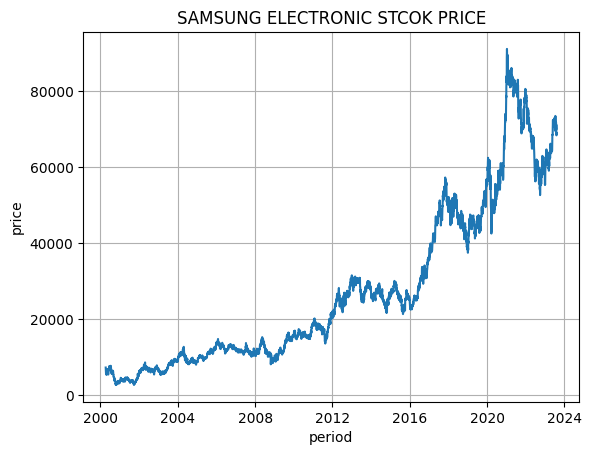

In [231]:
import matplotlib.pyplot as plt
plt.title('SAMSUNG ELECTRONIC STCOK PRICE')
plt.ylabel('price')
plt.xlabel('period')
plt.grid()

plt.plot(df['Close'], label='Close')

plt.show()

In [232]:
# 35개의 시간 지연 특징 생성
for i in range(1, 36):
    df[f'lag_{i}'] = df['Close'].shift(i)

# 특징과 목표 변수 분리
# X = df.drop('Close', axis=1)
X = df
y = df['Close']

# 학습 및 예측 데이터 분리
training_end_date = pd.to_datetime("2021-12-31")
prediction_start_date = pd.to_datetime("2022-01-01")

X_train = X[X.index <= training_end_date]
y_train = y[y.index <= training_end_date]

X_predict = X[X.index >= prediction_start_date]
y_true = y[y.index >= prediction_start_date]

<ipython-input-232-df556184ae18>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'lag_{i}'] = df['Close'].shift(i)
<ipython-input-232-df556184ae18>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'lag_{i}'] = df['Close'].shift(i)
<ipython-input-232-df556184ae18>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [233]:
# LightGBM 회귀 모델 생성 및 학습
model = LGBMRegressor()
model.fit(X_train, y_train)

# 2023년의 데이터에 대해 주가 다음날 종가 예측 수행
y_predicted = model.predict(X_predict)

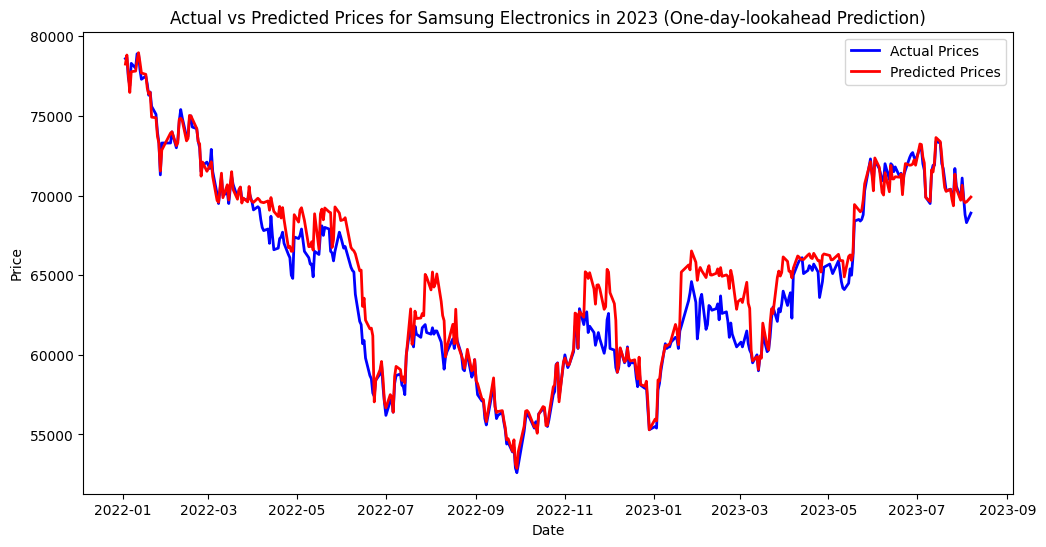

In [234]:
# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(y_true.index, y_true, label="Actual Prices", color="blue", linewidth=2)
plt.plot(y_true.index, y_predicted, label="Predicted Prices", color="red", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Actual vs Predicted Prices for Samsung Electronics in 2023 (One-day-lookahead Prediction)")
plt.legend()
plt.show()

In [235]:
from sklearn.metrics import accuracy_score

# 실제 방향성(true_direction) 및 예측 방향성(predicted_direction) 계산
true_direction = np.sign(y_true.diff()[1:])
predicted_direction = np.sign(np.diff(y_predicted))

# 정확도 계산z
accuracy = accuracy_score(true_direction, predicted_direction)
print(f"Accuracy of price direction predictions for 2023: {accuracy * 100:.2f}%")

# 전체적으로 몇 번 맞추었는지 계산
correct_count = np.sum(true_direction == predicted_direction)
total_count = len(true_direction)
print(f"Correct price direction predictions in 2023: {correct_count}/{total_count}")


Accuracy of price direction predictions for 2023: 85.03%
Correct price direction predictions in 2023: 335/394


2023년의 상승or하락을 예상하도록 했더니, 147일 중 120일을 맞췄습니다. 나쁘지 않은 결과인 것 같습니다.

In [236]:
# 예측한 변동률 및 실제 변동률 계산
predicted_pct_change = np.diff(y_predicted) / y_predicted[:-1] * 100
actual_pct_change = y_true.pct_change()[1:].values * 100

# 각 날짜별로 인공지능이 예측한 변동률과 실제 변동률을 DataFrame으로 표시
comparison_df = pd.DataFrame(data={'Predicted Change (%)': predicted_pct_change,
                                   'Actual Change (%)': actual_pct_change},
                             index=y_true.index[1:])

# 변동률 차이 및 방향 맞춤 여부 계산
difference = abs(predicted_pct_change - actual_pct_change)
correct_direction = (np.sign(predicted_pct_change) == np.sign(actual_pct_change))

# 차이와 방향 맞춤 여부를 DataFrame에 추가
comparison_df['Difference (%)'] = difference
comparison_df['Direction Correct'] = correct_direction

print(comparison_df)
print("mean of difference :", difference.mean())

            Predicted Change (%)  Actual Change (%)  Difference (%)  \
Date                                                                  
2022-01-04              0.726593           0.127226        0.599367   
2022-01-05             -1.578084          -1.651842        0.073758   
2022-01-06             -1.425433          -0.645995        0.779438   
2022-01-07              1.705547           1.820546        0.114999   
2022-01-10              0.048394          -0.383142        0.431536   
...                          ...                ...             ...   
2023-08-01              1.344530           1.862464        0.517934   
2023-08-02             -1.323033          -1.687764        0.364731   
2023-08-03             -0.218191          -1.573677        1.355486   
2023-08-04              0.062220          -0.726744        0.788964   
2023-08-07              0.438487           0.878477        0.439990   

            Direction Correct  
Date                           
2022-01-04  

In [237]:
# 8월 7일 예측을 위해 가장 최근 35일 데이터 가져오기 (시간 지연 특징 사용)
most_recent_35_days = df.iloc[-36:-1,:]
# most_recent_35_days = df.tail(35)
latest_35_lags = most_recent_35_days

# 8월 7일에 대한 종가 예측 수행
tomorrow_prediction = model.predict(latest_35_lags)
tomorrow_predicted_price = tomorrow_prediction[-1]

print(f"Predicted closing price for August 7th, 2023: {tomorrow_predicted_price:.2f}")


Predicted closing price for August 7th, 2023: 69602.48


내일은 8월 7일이고, 삼성전자의 현재 주가는 68300원 입니다. 제 모델은 상승을 예측했군요.

<br>

과연 실제로도 맞출 수 있을지 궁금합니다. 내일 확인해보겠습니다.